In [8]:
import time
import numpy as np
import pandas as pd
import os
import json
import re

In [2]:
from bs4 import BeautifulSoup
import requests

In [3]:
def get_h(author_id):

    semsch_author = "https://www.semanticscholar.org/author/"
    author_id = author_id
    response = requests.get(semsch_author + author_id)

    if response.ok:
        soup = BeautifulSoup(response.text)
        author_natural_name = soup.title.text[:-19]
        author = {
            "name": author_natural_name,
            "id": author_id,
        }
        #print("{} ({})\n---".format(author_natural_name, author_id))

        for div in soup.find_all("div", class_="author-detail-card__stats-row"):
            label = div.find("span", class_="author-detail-card__stats-row__label")
        
            if label.text == "Publications":        
                elem = label
                for _ in range(2):
                    elem = elem.next
                author["publications"] = int(elem.text)
        
            elif label.text == "h-index":        
                elem = label
                for _ in range(5):
                    elem = elem.next
                author["h-index"] = int(elem.text)
        
            elif label.text == "Citations":        
                elem = label
                for _ in range(2):
                    elem = elem.next
                author["citations"] = int(elem.text.replace(",", ""))
            
        #print(author["h-index"])
        return(author["h-index"])

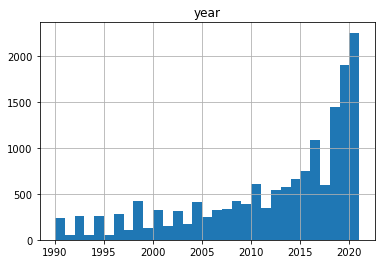

In [6]:
df = pd.read_csv("data/anthology_conferences.csv", sep="|", keep_default_na=False)

#for year in df.year.unique():
 
df.hist(column='year',bins=31);

In [ ]:
# takes ages

#df = pd.read_csv("data/anthology_conferences.csv", sep="|", keep_default_na=False)
#df = df.loc[0:2,:]

notfound = []
df["no_authors"] = ""
df["avg_h"] = ""
missing = 0

for i, row in df.iterrows():
    h = 0
    avg_h = 0
    no_authors = 0
    auths = row["semantic_scholar_authorIds"]
    auths = re.sub('\[|\]|\'|\,', '', auths).split()
    #print(type(row["semantic_scholar_authorIds"]))
    for auth in auths:
        #print(auth)
        try:
            h = get_h(auth)
            avg_h += h
            no_authors += 1
            
        except:
            notfound.append(auth) #catch missing authors
            missing += 1
    if no_authors != 0:
        df.at[i, "no_authors"] = no_authors
        df.at[i, "avg_h"] = avg_h/no_authors
    else:
        df.at[i, "no_authors"] = "NaN"
        df.at[i, "avg_h"] = "NaN"
    

print("missing {} authors".format(missing))  
print(notfound)
df

In [36]:
#df = pd.read_csv("data/anthology_conferences.csv", sep="|", keep_default_na=False)
#df = df.loc[0:3,:]

notfound = []
df["mean"] = ""
df["cov"] = ""
missing = 0
diffs = []
today = 2021


for i, row in df.iterrows():
    public_year = 0
    n_references = 0
    diffs.clear()
    file = "json/" + row["pdf"] + ".json"
    try:
        with open(file) as jf:
            paper = json.load(jf)
            #print(file)
            for reference in paper["metadata"]["references"]:
                diffs.append(paper["metadata"]["year"] - reference["year"]) # we miss a lot of referenced due to semanticscholar not having the publication years available in the json
    except:
        notfound.append(file) #catch missing jsons
        missing += 1

    #print(diffs)
    if len(diffs) == 0:
        df.at[i, "mean"] = "NaN"
        df.at[i, "cov"] = "NaN"
    else: 
        df.at[i, "mean"] = np.mean(diffs)
        # usually cov is calculated and multiplied times 100, reference paper doesn't do this though, so we will neither
        df.at[i, "cov"] = np.std(diffs, ddof=1) / np.mean(diffs) # ddof is the offset to chose from the no of papers to calculate std, in this case n-1; this reduces bias or something
    
print("missing {} jsons".format(missing))  
print(notfound)
df

json/2020.acl-main.1.pdf.json
[18, 3, 11, 1, 9, 1, 2, 3, 4, 17, 15, 23, 0, 7, 1, 4, 43, 4, 19, 1, 13, 7]
json/2020.acl-main.2.pdf.json
[2, 4, 44, 20, 2, 6, 25, 6, 7, 7, 3, 6, 1, 10, 3, 34, 15, 6, 1, 14, 3, 5, 9, 10, 2, 1, 1, 16, 3, 6, 6, 5, 7, 16, 6, 30, 1, 3, 6, 9, 2, 4, 3, 50, 1, 1]
json/2020.acl-main.3.pdf.json
[3, 3, 14, 2, 3, 2, 2, 2, 3, 23, 4, 1, 6, 4, 2, 1, 0, 1, 0, 1, 10, 9, 2, 1, 17, 3, 0, 3, 1, 3]
json/2020.acl-main.4.pdf.json
[]


,url,publisher,address,year,month,editor,title,ENTRYTYPE,ID,pages,...,isbn,language,number,note,pdf,abstract,semantic_scholar,semantic_scholar_authorIds,mean,cov
0,https://www.aclweb.org/anthology/2020.acl-main.1,Association for Computational Linguistics,Online,2020,July,,Learning to Understand Child-directed and Adul...,inproceedings,gelderloos-etal-2020-learning,1--6,...,,,,,2020.acl-main.1.pdf,Speech directed to children differs from adult...,2020.acl-main.1.json,"['7805500', '2756960', '103538973']",9.363636,1.090878
1,https://www.aclweb.org/anthology/2020.acl-main.2,Association for Computational Linguistics,Online,2020,July,,Predicting Depression in Screening Interviews ...,inproceedings,rinaldi-etal-2020-predicting,7--18,...,,,,,2020.acl-main.2.pdf,Despite the pervasiveness of clinical depressi...,2020.acl-main.2.json,"['19320780', '2457504', '37202877']",9.173913,1.208878
2,https://www.aclweb.org/anthology/2020.acl-main.3,Association for Computational Linguistics,Online,2020,July,,Coach: A Coarse-to-Fine Approach for Cross-dom...,inproceedings,liu-etal-2020-coach,19--25,...,,,,,2020.acl-main.3.pdf,As an essential task in task-oriented dialog s...,2020.acl-main.3.json,"['152613855', '9162688', '145011005', '40539650']",4.2,1.271311
3,https://www.aclweb.org/anthology/2020.acl-main.4,Association for Computational Linguistics,Online,2020,July,,Designing Precise and Robust Dialogue Response...,inproceedings,zhao-etal-2020-designing,26--33,...,,,,,2020.acl-main.4.pdf,Automatic dialogue response evaluator has been...,2020.acl-main.4.json,"['46887780', '1939089', '1717105']",NaN,NaN


In [29]:
# Get most recent citation count from Semantic Scholar
# probably also takes at least a year
df = pd.read_csv("data/anthology_conferences.csv", sep="|", keep_default_na=False)
df = df.loc[0:500,:]


import re
citations = 0
semsch_paper = "https://www.semanticscholar.org/paper/"
notfound = []
missing = 0
df["citations"] = ""


for i, row in df.iterrows():
    json_path = "semantic_scholar/papers/" + row["semantic_scholar"]
    try:
        with open(json_path) as jf:
            paper = json.load(jf)
            paper_id = paper["paperId"]
            #print(paper_id)
            response = requests.get(semsch_paper + paper_id)
            
        if response.ok:
            soup = BeautifulSoup(response.text)
            paper_detail_title = soup.title.text
            div = soup.find("div", class_="scorecard-stat__body")
                
            if div != None:
                label = div.find("span", class_="scorecard-stat__headline")
                citations = re.sub('[^0-9]', '', label.text)
                #print(citations)
            else:
                print("No Citation count available")
                missing +=1
                citations = "NaN"
            #print(div)
            #print("{} citations in {}".format(citations, paper_detail_title))
        
        else:
            print("soup failed for {}".format(paper))    
        
        df.at[i, "citations"] = citations

    except:
        notfound.append(json_path) #catch missing jsons

print(missing)
print(notfound)
df

No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count available
No Citation count av

,url,publisher,address,year,month,editor,title,ENTRYTYPE,ID,pages,...,doi,isbn,language,number,note,pdf,abstract,semantic_scholar,semantic_scholar_authorIds,citations
0,https://www.aclweb.org/anthology/2020.acl-main.1,Association for Computational Linguistics,Online,2020,July,,Learning to Understand Child-directed and Adul...,inproceedings,gelderloos-etal-2020-learning,1--6,...,10.18653/v1/2020.acl-main.1,,,,,2020.acl-main.1.pdf,Speech directed to children differs from adult...,2020.acl-main.1.json,"['7805500', '2756960', '103538973']",NaN
1,https://www.aclweb.org/anthology/2020.acl-main.2,Association for Computational Linguistics,Online,2020,July,,Predicting Depression in Screening Interviews ...,inproceedings,rinaldi-etal-2020-predicting,7--18,...,10.18653/v1/2020.acl-main.2,,,,,2020.acl-main.2.pdf,Despite the pervasiveness of clinical depressi...,2020.acl-main.2.json,"['19320780', '2457504', '37202877']",NaN
2,https://www.aclweb.org/anthology/2020.acl-main.3,Association for Computational Linguistics,Online,2020,July,,Coach: A Coarse-to-Fine Approach for Cross-dom...,inproceedings,liu-etal-2020-coach,19--25,...,10.18653/v1/2020.acl-main.3,,,,,2020.acl-main.3.pdf,As an essential task in task-oriented dialog s...,2020.acl-main.3.json,"['152613855', '9162688', '145011005', '40539650']",16
3,https://www.aclweb.org/anthology/2020.acl-main.4,Association for Computational Linguistics,Online,2020,July,,Designing Precise and Robust Dialogue Response...,inproceedings,zhao-etal-2020-designing,26--33,...,10.18653/v1/2020.acl-main.4,,,,,2020.acl-main.4.pdf,Automatic dialogue response evaluator has been...,2020.acl-main.4.json,"['46887780', '1939089', '1717105']",8
4,https://www.aclweb.org/anthology/2020.acl-main.5,Association for Computational Linguistics,Online,2020,July,,Dialogue State Tracking with Explicit Slot Con...,inproceedings,ouyang-etal-2020-dialogue,34--40,...,10.18653/v1/2020.acl-main.5,,,,,2020.acl-main.5.pdf,Recent proposed approaches have made promising...,2020.acl-main.5.json,"['2070558572', '1753948811', '40539275', '2651...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,https://www.aclweb.org/anthology/2020.acl-main...,Association for Computational Linguistics,Online,2020,July,,Benefits of Intermediate Annotations in Readin...,inproceedings,dua-etal-2020-benefits,5627--5634,...,10.18653/v1/2020.acl-main.497,,,,,2020.acl-main.497.pdf,"Complex, compositional reading comprehension d...",2020.acl-main.497.json,"['33546336', '34650964', '40642935']",10
497,https://www.aclweb.org/anthology/2020.acl-main...,Association for Computational Linguistics,Online,2020,July,,Crossing Variational Autoencoders for Answer R...,inproceedings,yu-etal-2020-crossing,5635--5641,...,10.18653/v1/2020.acl-main.498,,,,,2020.acl-main.498.pdf,Answer retrieval is to find the most aligned a...,2020.acl-main.498.json,"['38767143', '3008832', '1694209', '152710186'...",4
498,https://www.aclweb.org/anthology/2020.acl-main...,Association for Computational Linguistics,Online,2020,July,,Logic-Guided Data Augmentation and Regularizat...,inproceedings,asai-hajishirzi-2020-logic,5642--5650,...,10.18653/v1/2020.acl-main.499,,,,,2020.acl-main.499.pdf,Many natural language questions require qualit...,2020.acl-main.499.json,"['35584853', '2548384']",17
499,https://www.aclweb.org/anthology/2020.acl-main...,Association for Computational Linguistics,Online,2020,July,,On the Importance of Diversity in Question Gen...,inproceedings,sultan-etal-2020-importance,5651--5656,...,10.18653/v1/2020.acl-main.500,,,,,2020.acl-main.500.pdf,Automatic question generation (QG) has shown p...,2020.acl-main.500.json,"['2937809', '145536500', '3394760', '2879453']",10


In [11]:
#TESTEST

testpaperpath = "semantic_scholar/papers/" + "P19-1658" + ".json"
testpaper = json.load(open(testpaperpath))
testpapertext = ""
#print(testpaper.keys())
#print(testpaper["metadata"].keys())
#print(testpaper["metadata"]["sections"])

'''for item in testpaper["metadata"]["sections"]:
    #print(item["heading"])
    if item["heading"] != None:
        #print(item["heading"])
        testpapertext = testpapertext + item["text"]'''
          
print(testpaper["paperId"])

37fa5e2ab18e4c69b060b66bd602b55adddc0ba2


In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

df["ID", "no_authors", "avg_h", "mean", "cov", ]

X, y = make_regression(n_samples=2000, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
...                                                     random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
regr.predict(X_test[:2])
array([-0.9..., -7.1...])
regr.score(X_test, y_test)
0.4...

dict_keys(['name', 'metadata'])
-18
-3
-11
-1
-9
-1
-2
-3
-4
-17
-15
-23
0
-7
-1
-4
-43
-4
-19
-1
-13
-7
2020
